In [1]:
# ==============================================================================
# 1. Kütüphane Yükleme ve Ayarlar
# ==============================================================================
!pip install soundfile torchaudio numpy tqdm scikit-learn matplotlib

import torch
import torchaudio
import os
import glob
import shutil
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import soundfile as sf
from itertools import groupby # Sayım için gerekli

print("Gerekli kütüphaneler yüklendi.")

Gerekli kütüphaneler yüklendi.


In [2]:
# --- Ayarlar ---
SAMPLE_RATE = 16000
DURATION = 3 # Modelin sınıflandıracağı her pencerenin uzunluğu
INPUT_LENGTH = SAMPLE_RATE * DURATION # 48000 örnek
BATCH_SIZE = 8 # GPU hafızasını rahatlatmak için küçültüldü
EPOCHS = 20

In [3]:
# ==============================================================================
# 2. Veri Taşıma ve Ön İşleme
# ==============================================================================
from google.colab import drive
from tqdm import tqdm

drive.mount('/content/drive')

# Kaynak Yolları (Kendi Drive yolunuza göre güncelleyin)
healthy_source = '/content/drive/MyDrive/Colab Notebooks/İşaretlenenler/healthy/other'
asthma_source = '/content/drive/MyDrive/Colab Notebooks/İşaretlenenler/asthma'
base_target = '/content/dataset'
cough_target_dir = os.path.join(base_target, 'cough')
noise_target_dir = os.path.join(base_target, 'noise')

if os.path.exists(base_target): shutil.rmtree(base_target)
os.makedirs(cough_target_dir); os.makedirs(noise_target_dir)

def copy_files(source_folder, target_folder):
    count = 0
    for root, dirs, files in os.walk(source_folder):
        for file in files:
            if file.lower().endswith('.wav'):
                shutil.copy(os.path.join(root, file), os.path.join(target_folder, file))
                count += 1
    return count

print("Dosyalar taranıyor ve 'cough' klasörüne kopyalanıyor...")
h_count = copy_files(healthy_source, cough_target_dir)
a_count = copy_files(asthma_source, cough_target_dir)
total_cough_count = h_count + a_count
print(f"Toplam Öksürük Dosyası (Pozitif Sınıf): {total_cough_count}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dosyalar taranıyor ve 'cough' klasörüne kopyalanıyor...
Toplam Öksürük Dosyası (Pozitif Sınıf): 1144


In [4]:
# ==============================================================================
# 3. Negatif Sınıf (Gürültü) Üretimi
# ==============================================================================

def create_noise_files(source_dir, noise_target_dir, num_per_file=10, duration=3): # num_per_file=10 artırıldı
    all_files = glob.glob(os.path.join(source_dir, "*.wav"))
    target_length = SAMPLE_RATE * duration

    print(f"-> {len(all_files)} dosyadan Gürültü (Negatif) örnekler üretiliyor...")

    for wav_path in tqdm(all_files):
        try:
            audio_np, sr = sf.read(wav_path, dtype='float32'); waveform = torch.from_numpy(audio_np).float()

            # Ön İşleme ve Resample
            if waveform.ndim == 1: waveform = waveform.unsqueeze(0)
            elif waveform.shape[1] > waveform.shape[0]: waveform = waveform.T
            if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
            if sr != SAMPLE_RATE:
                resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE); waveform = resampler(waveform)

            total_length = waveform.shape[1]
            if total_length < target_length * 1.5: continue

            for i in range(num_per_file):
                start_point = random.randint(0, total_length - target_length)
                noise_slice = waveform[:, start_point:start_point + target_length]
                noise_path = os.path.join(noise_target_dir, f"{os.path.basename(wav_path).replace('.wav', '')}_noise_{i}.wav")
                torchaudio.save(noise_path, noise_slice, SAMPLE_RATE)

        except Exception:
            continue

    print(f"-> Gürültü dosyaları oluşturuldu. Toplam Gürültü Sayısı: {len(glob.glob(os.path.join(noise_target_dir, '*.wav')))}")

create_noise_files(cough_target_dir, noise_target_dir, num_per_file=10) # 10 kat gürültü

-> 1144 dosyadan Gürültü (Negatif) örnekler üretiliyor...


100%|██████████| 1144/1144 [00:00<00:00, 8042.90it/s]

-> Gürültü dosyaları oluşturuldu. Toplam Gürültü Sayısı: 0


In [5]:
# ==============================================================================
# 4. Veri Yükleyici (Olay Tespiti Dataset)
# ==============================================================================

class CoughEventDetectionDataset(Dataset):
    def __init__(self, file_paths, labels, target_length):
        self.file_paths = file_paths; self.labels = labels; self.target_length = target_length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]; label = self.labels[idx]

        # --- Ses Okuma (Soundfile Fix) ---
        audio_np, sr = sf.read(path, dtype='float32'); waveform = torch.from_numpy(audio_np).float()

        if waveform.ndim == 1: waveform = waveform.unsqueeze(0)
        elif waveform.shape[1] > waveform.shape[0]: waveform = waveform.T
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if sr != SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE); waveform = resampler(waveform)

        # Uzunluk sabitleme (Padding/Kırpma)
        if waveform.shape[1] > self.target_length:
            waveform = waveform[:, :self.target_length]
        elif waveform.shape[1] < self.target_length:
            padding = self.target_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))

        return waveform, label

# --- Veri Yolu Tanımlama ve Ayırma ---
cough_files = glob.glob(os.path.join(cough_target_dir, "*.wav"))
noise_files = glob.glob(os.path.join(noise_target_dir, "*.wav"))

X = cough_files + noise_files
y = [1] * len(cough_files) + [0] * len(noise_files)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

train_dataset = CoughEventDetectionDataset(X_train, y_train, INPUT_LENGTH)
test_dataset = CoughEventDetectionDataset(X_test, y_test, INPUT_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Olay Tespiti Veri Seti Hazır! Pozitif/Negatif Oranı Dengelendi.")

Olay Tespiti Veri Seti Hazır! Pozitif/Negatif Oranı Dengelendi.


In [6]:
# ==============================================================================
# 5. SincNet Mimarisi (Olay Tespiti Modeli)
# ==============================================================================

class SincConv_fast(nn.Module):
    # SincConv_fast sınıfının düzeltilmiş başlatma metodu
    def __init__(self, out_channels, kernel_size, sample_rate=16000, in_channels=1, min_low_hz=50, min_band_hz=50):
        super(SincConv_fast, self).__init__()

        # --- TÜM TEMEL self. NİTELİKLERİNİN ÖNCELİKLE ATANMASI ---
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        if kernel_size % 2 == 0: self.kernel_size = self.kernel_size + 1
        self.sample_rate = sample_rate # HATA KAYNAĞI BU SATIRIN GEÇ GELMESİYDİ.
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz
        # --------------------------------------------------------------------

        low_hz = 30
        # self.sample_rate artık kullanılabilir
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)
        mel = np.linspace(self.to_mel(low_hz), self.to_mel(high_hz), self.out_channels + 1)
        hz = self.to_hz(mel)

        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

        n_lin = torch.linspace(1, (self.kernel_size / 2), int((self.kernel_size / 2)))
        window_ = 0.54 - 0.46 * torch.cos(2 * np.pi * n_lin / self.kernel_size)

        # Hata veren kısım: Şimdi güvenli bir şekilde self.sample_rate'e erişebiliriz.
        n_ = 2 * np.pi * n_lin / self.sample_rate
        n_ = n_.view(1, -1)

        self.register_buffer('window_', window_)
        self.register_buffer('n_', n_)

    def to_mel(self, hz): return 2595 * np.log10(1 + hz / 700)
    def to_hz(self, mel): return 700 * (10 ** (mel / 2595) - 1)

    def forward(self, waveforms):
        low = self.min_low_hz + torch.abs(self.low_hz_); high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_), self.min_low_hz, self.sample_rate / 2)
        band = (high - low)[:, 0]; f_times_t_low = torch.matmul(low, self.n_); f_times_t_high = torch.matmul(high, self.n_)
        band_pass_left = ((torch.sin(f_times_t_high) - torch.sin(f_times_t_low)) / (self.n_ / 2)) * self.window_
        band_pass_center = 2 * band.view(-1, 1); band_pass_right = torch.flip(band_pass_left, dims=[1])
        filters = torch.cat([band_pass_left, band_pass_center, band_pass_right], dim=1)
        filters = filters.view(self.out_channels, 1, self.kernel_size)
        return F.conv1d(waveforms, filters, stride=1, padding=self.kernel_size // 2)


class SincNetEventDetector(nn.Module):
    def __init__(self):
        super(SincNetEventDetector, self).__init__()

        self.sinc_conv = SincConv_fast(out_channels=80, kernel_size=251, sample_rate=16000)
        self.layer_norm = nn.LayerNorm([80, INPUT_LENGTH])

        self.conv2 = nn.Conv1d(80, 60, kernel_size=5); self.bn2 = nn.BatchNorm1d(60); self.pool2 = nn.MaxPool1d(3)
        self.conv3 = nn.Conv1d(60, 60, kernel_size=5); self.bn3 = nn.BatchNorm1d(60); self.pool3 = nn.MaxPool1d(3)

        self.dropout = nn.Dropout(p=0.5)

        with torch.no_grad():
             dummy = torch.zeros(1, 1, INPUT_LENGTH)
             x = self.sinc_conv(dummy); x = self.layer_norm(x)
             x = self.pool2(F.leaky_relu(self.bn2(self.conv2(x)))); x = self.pool3(F.leaky_relu(self.bn3(self.conv3(x))))
             flatten_dim = x.shape[1] * x.shape[2]

        self.flatten = nn.Flatten(); self.fc1 = nn.Linear(flatten_dim, 128); self.bn_fc1 = nn.BatchNorm1d(128); self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.leaky_relu(self.layer_norm(self.sinc_conv(x))); x = self.pool2(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.leaky_relu(self.bn3(self.conv3(x)))); x = self.flatten(x)

        x = self.dropout(x)
        x = F.leaky_relu(self.bn_fc1(self.fc1(x)))

        return torch.sigmoid(self.fc2(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SincNetEventDetector().to(device)

print("SincNetEventDetector Modeli başarıyla oluşturuldu. Eğitim başlayabilir.")

SincNetEventDetector Modeli başarıyla oluşturuldu. Eğitim başlayabilir.


In [7]:
# ==============================================================================
# 6. Kayıp Fonksiyonu ve Optimizer (YENİ AYARLAR)
# ==============================================================================
criterion = nn.BCELoss() # Binary Cross Entropy Loss kullanılmaya devam eder

# KRİTİK DEĞİŞİKLİK:
# lr=0.00001 (10 kat düşürüldü) ve weight_decay=1e-3 (10 kat artırıldı)
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-3)

history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}

In [8]:
# ==============================================================================
# 7. Eğitim (Training) Döngüsü
# ==============================================================================

def run_epoch(loader, is_train=True):
    model.train() if is_train else model.eval()
    total_loss = 0; correct = 0; total = 0

    desc = "Eğitim" if is_train else "Test"
    loop = tqdm(loader, desc=desc, leave=False)

    with torch.set_grad_enabled(is_train):
        for inputs, labels in loop:
            inputs = inputs.to(device); labels = labels.float().unsqueeze(1).to(device)

            if is_train: optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if is_train:
                if torch.isnan(loss): continue
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            total_loss += loss.item()

            predicted = (outputs > 0.5).float(); total += labels.size(0)
            correct += (predicted == labels).sum().item(); loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader) if len(loader) > 0 else 0
    avg_acc = 100 * correct / total if total > 0 else 0
    return avg_loss, avg_acc

print("\n--- SINC-CNN OLAY TESPİTİ EĞİTİMİ BAŞLIYOR ---")
for epoch in range(EPOCHS):
    train_loss, train_acc = run_epoch(train_loader, is_train=True)
    test_loss, test_acc = run_epoch(test_loader, is_train=False)

    print(f"Epoch {epoch+1}/{EPOCHS} -> "
          f"Train: Loss={train_loss:.4f}, Acc=%{train_acc:.2f} | "
          f"Test: Loss={test_loss:.4f}, Acc=%{test_acc:.2f}")

    history['train_loss'].append(train_loss); history['test_loss'].append(test_loss)
    history['train_acc'].append(train_acc); history['test_acc'].append(test_acc)


--- SINC-CNN OLAY TESPİTİ EĞİTİMİ BAŞLIYOR ---


Epoch 1/20 -> Train: Loss=0.7961, Acc=%30.82 | Test: Loss=0.7337, Acc=%36.68


Epoch 2/20 -> Train: Loss=0.7412, Acc=%38.69 | Test: Loss=0.6711, Acc=%62.01


Epoch 3/20 -> Train: Loss=0.6851, Acc=%55.30 | Test: Loss=0.5874, Acc=%87.77


Epoch 4/20 -> Train: Loss=0.6365, Acc=%69.51 | Test: Loss=0.5710, Acc=%88.65


Epoch 5/20 -> Train: Loss=0.5937, Acc=%81.09 | Test: Loss=0.4839, Acc=%93.89


Epoch 6/20 -> Train: Loss=0.5528, Acc=%89.07 | Test: Loss=0.4716, Acc=%96.51


Epoch 7/20 -> Train: Loss=0.5197, Acc=%93.55 | Test: Loss=0.3965, Acc=%98.25


Epoch 8/20 -> Train: Loss=0.4833, Acc=%96.72 | Test: Loss=0.4370, Acc=%96.07


Epoch 9/20 -> Train: Loss=0.4530, Acc=%97.70 | Test: Loss=0.3972, Acc=%97.82


Epoch 10/20 -> Train: Loss=0.4226, Acc=%98.80 | Test: Loss=0.3600, Acc=%97.82


Epoch 11/20 -> Train: Loss=0.3929, Acc=%99.45 | Test: Loss=0.3580, Acc=%97.38


Epoch 12/20 -> Train: Loss=0.3722, Acc=%99.89 | Test: Loss=0.3157, Acc=%98.25


Epoch 13/20 -> Train: Loss=0.3483, Acc=%100.00 | Test: Loss=0.3154, Acc=%98.25


Epoch 14/20 -> Train: Loss=0.3184, Acc=%100.00 | Test: Loss=0.2935, Acc=%98.25


Epoch 15/20 -> Train: Loss=0.3019, Acc=%100.00 | Test: Loss=0.2961, Acc=%98.25


Epoch 16/20 -> Train: Loss=0.2830, Acc=%100.00 | Test: Loss=0.2549, Acc=%100.00


Epoch 17/20 -> Train: Loss=0.2671, Acc=%99.89 | Test: Loss=0.2435, Acc=%99.56


Epoch 18/20 -> Train: Loss=0.2472, Acc=%100.00 | Test: Loss=0.2379, Acc=%99.56


Epoch 19/20 -> Train: Loss=0.2324, Acc=%99.89 | Test: Loss=0.2348, Acc=%99.56


Epoch 20/20 -> Train: Loss=0.2179, Acc=%100.00 | Test: Loss=0.2009, Acc=%99.56


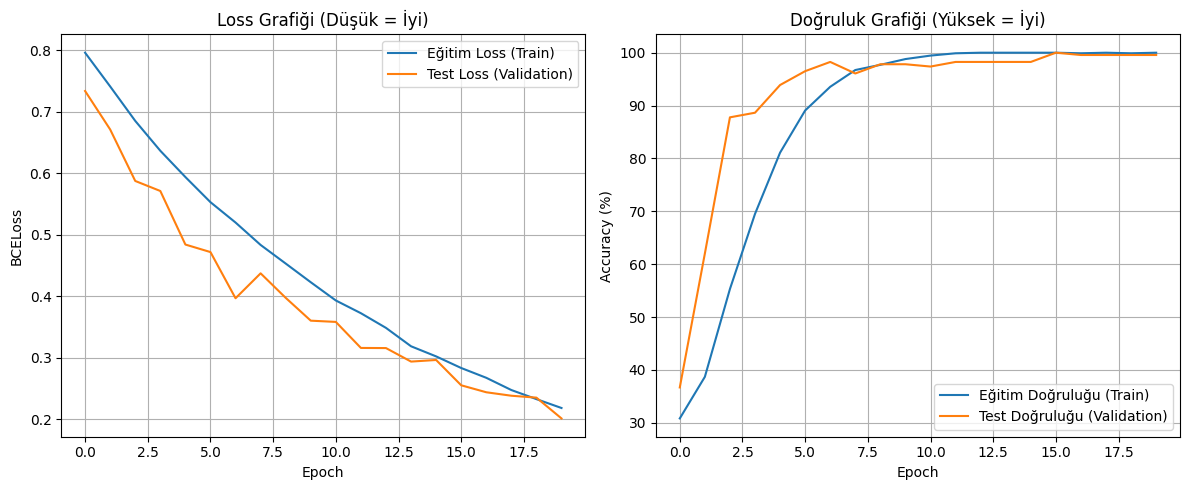


--- GRAFİK YORUMU ---
İYİ: Model dengeli ve başarılı. Test Doğruluğu: %99.56

--- BAŞLATILAN OLAY TESPİTİ (YENİ MODEL) ---

--- DOSYA: test_sesi.wav ---
Toplam Pencere Sayısı: 10
Tahmin Edilen Toplam Öksürük Sayısı: 1

--- DOSYA: 1 (23).wav ---
Toplam Pencere Sayısı: 1
Tahmin Edilen Toplam Öksürük Sayısı: 1

--- DOSYA: 1 (29).wav ---
Toplam Pencere Sayısı: 9
Tahmin Edilen Toplam Öksürük Sayısı: 1


In [9]:
# ==============================================================================
# 8. Grafiksel Analiz ve Tahmin (Uzun Kayıtlar)
# ==============================================================================

# Grafiksel Analiz
epochs_range = range(EPOCHS)
plt.figure(figsize=(12, 5))
# Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Eğitim Loss (Train)')
plt.plot(epochs_range, history['test_loss'], label='Test Loss (Validation)')
plt.title('Loss Grafiği (Düşük = İyi)'); plt.xlabel('Epoch'); plt.ylabel('BCELoss'); plt.legend(loc='upper right'); plt.grid(True)
# Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Eğitim Doğruluğu (Train)')
plt.plot(epochs_range, history['test_acc'], label='Test Doğruluğu (Validation)')
plt.title('Doğruluk Grafiği (Yüksek = İyi)'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(loc='lower right'); plt.grid(True)
plt.tight_layout(); plt.show()

# Overfitting Yorumu
print("\n--- GRAFİK YORUMU ---")
if history['train_acc']:
    final_train_acc = history['train_acc'][-1]; final_test_acc = history['test_acc'][-1]
    if final_train_acc > final_test_acc + 5:
        print(f"UYARI: Aşırı Öğrenme (Overfitting) devam ediyor. Fark: {final_train_acc - final_test_acc:.2f}%. Test Doğruluğu: %{final_test_acc:.2f}")
    elif final_test_acc > 75:
        print(f"İYİ: Model dengeli ve başarılı. Test Doğruluğu: %{final_test_acc:.2f}")
    else:
        print(f"DURUM: Model zayıf performans gösteriyor. Test Doğruluğu: %{final_test_acc:.2f}")


# UZUN KAYITLARDA TAHMİN
TEST_FILES = ['test_sesi.wav', '1 (23).wav', '1 (29).wav']
stride_length = SAMPLE_RATE * 1

def load_long_audio_for_prediction(filepath, sample_rate=16000):
    audio_np, sr = sf.read(filepath, dtype='float32'); waveform = torch.from_numpy(audio_np).float()
    if waveform.ndim == 1: waveform = waveform.unsqueeze(0)
    elif waveform.shape[1] > waveform.shape[0]: waveform = waveform.T
    if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(sr, sample_rate); waveform = resampler(waveform)
    return waveform

def count_coughs_in_long_audio(long_audio_path, model, device, input_length, stride):
    if not os.path.exists(long_audio_path): raise FileNotFoundError(f"Dosya bulunamadı: {long_audio_path}")
    model.eval(); full_waveform = load_long_audio_for_prediction(long_audio_path, SAMPLE_RATE)
    total_length = full_waveform.shape[1]; predictions = []
    for start_idx in range(0, total_length, stride):
        end_idx = start_idx + input_length; audio_slice = full_waveform[:, start_idx:end_idx]
        if audio_slice.shape[1] < input_length:
            padding = input_length - audio_slice.shape[1]; audio_slice = torch.nn.functional.pad(audio_slice, (0, padding))
        input_tensor = audio_slice.to(device).unsqueeze(0)

        with torch.no_grad(): output = model(input_tensor); predictions.append(output.cpu().item())
        if end_idx >= total_length: break

    threshold = 0.5
    class_preds = [1 if pred > threshold else 0 for pred in predictions]

    # Ardışık Deteği Gruplama (Capuchinbird sayım mantığı)
    postprocessed_preds = [key for key, group in groupby(class_preds) if key == 1]
    total_coughs = len(postprocessed_preds)

    return total_coughs, class_preds

print("\n--- BAŞLATILAN OLAY TESPİTİ (YENİ MODEL) ---")
for file in TEST_FILES:
    try:
        total_coughs, raw_predictions = count_coughs_in_long_audio(
            file, model, device, INPUT_LENGTH, stride_length)

        print(f"\n--- DOSYA: {file} ---")
        print(f"Toplam Pencere Sayısı: {len(raw_predictions)}")
        print(f"Tahmin Edilen Toplam Öksürük Sayısı: {total_coughs}")

    except FileNotFoundError as e:
        print(f"\nHATA: {e}")
    except NameError:
        print("\nHATA: Model yüklenmemiş.")
    except Exception as e:
        print(f"\nHATA: Beklenmedik bir hata oluştu: {e}")